# PMR3404 - Controle I
# Projeto Final (Ball on Wheel)

#### Bruno Fernandes Maione (10770631)
#### Victor Kowalski Martins (10770482)

#### Professores: Eduardo Aoun Tannuri e Newton Maruyama

#### Julho 2021

# PMR3404 - Control I
# Final Project (Ball on Wheel)

#### Bruno Fernandes Maione (10770631)
#### Victor Kowalski Martins (10770482)

#### Teachers: Eduardo Aoun Tannuri and Newton Maruyama

#### July 2021

In [1]:
# Aqui importamos todas as bibliotecas que serão utilizadas no projeto

from sympy import *
from grafico_margens import plot_margins
import warnings
init_printing(use_unicode=True)
warnings.filterwarnings('ignore')
import control.matlab as co
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

### 1. Introduction

This work aims to model the control for a system called "Ball on Wheel". It consists of a wheel, with non-negligible inertia and driven by a DC motor, on which a ball must be balanced. A position sensor measures the ball's displacement with respect to the vertical axis (ie, the $y(t)$ variable). The purpose of the control system is to keep the ball on top of the wheel. It is assumed that there is no slippage between the parts.

The Figure below shows a real photo of the system together with a schematic drawing.

![Picture title](Pictures/Real_Esquema.png)

The ball has mass $m$, moment of inertia $\vartheta$ and radius $r$. The wheel has $\Theta$ moment of inertia and $R$ radius.

Wheel torque is given by $\tau(t)$. The angular position of the wheel relative to the vertical axis is given by $\psi(t)$, the angular position of the ball around the center of the wheel is described by $\chi(t)$ and the linear displacement with respect to the vertical axis, assuming no slip, is given by: $y(t) = (R+r)sin(\chi(t))$ .

Therefore, considering that the equations of motion, motor dynamics and the physical parameters of the system were exposed in the statement (and will also be exposed throughout the development), it is possible to proceed to the analysis of the plant for a subsequent dimensioning of the controller passed over.

### 2. Details of the Plant

The first step to be carried out for this project is the definition and simplification of the equations of motion, which will have to be analyzed for a future construction of the block diagram of our plant.

As we will work with small angles and, mainly, to enable the posterior laplace transforms, the following approximation will be used for the sines:

$$
sin(x) = x
$$

Such approximation, adapted from the first fundamental limit of the Calculus, works for angles smaller than 14º with an error of less than 1%, which is a perfectly satisfactory precision for the project.

In [2]:
# Definindo as equações de movimento

t = symbols('t')
s = symbols('s')
m = symbols('m')
r = symbols('r')
R = symbols('R')
g = symbols('g')
v = symbols('vartheta')
O = symbols('Theta')
n = symbols('n')
Kt = symbols('K_t')
Kv = symbols('K_v')
Lm = symbols('L_m')
Rm = symbols('R_m')
T = symbols('Gamma')

y, psi, chi, u, i, V = symbols('y, psi, chi, u, i, V', cls=Function)

y = y(t)
y_dot = y.diff()
y_ddot = y_dot.diff()

psi = psi(t)
psi_dot = psi.diff()
psi_ddot = psi_dot.diff()

chi = chi(t)
chi_dot = chi.diff()
chi_ddot = chi_dot.diff()

u = u(t)
u_dot = u.diff()
u_ddot = u_dot.diff()

i = i(t)
i_dot = i.diff()
i_ddot = i_dot.diff()

V = V(t)
V_dot = V.diff()
V_ddot = V_dot.diff()

eq_y = Eq(y ,(R+r)*chi)
eq_psi_ddot = Eq(psi_ddot ,((m*(r**2) + v)*u + m*g*R*v*chi)/T)
eq_chi_ddot = Eq(chi_ddot ,(v*R*u + (O*(r**2) + v*(R**2))*m*g*chi)/(T*(r+R)))
eq_u = Eq(u ,n*Kt*i)
eq_V = Eq(V, Lm*i_dot + Rm*i + Kv*psi_dot)

Once with the equations defined in the code, we can carry out the manipulations in the frequency domain, with the laplace transforms.

As the Sympy library in Python doesn't have native support for laplace transforms with derivatives and integrals, we must define a function (that takes advantage of the native library basics) to cover such functionalities and allow the use along the deductions, since these peculiarities would definitely be used.

In [3]:
def laplace_completa(e, t, s):
    """
        Função completa adaptada da biblioteca da transformada de laplace, acrescido do suporte à derivadas e integrais.
        Adaptada de: https://github.com/sympy/sympy/issues/7219#issuecomment-154768904

        Parâmetros
            Inputs: e (expressão simbólica à ser transformada), t (simbólico que representa o tempo), s (simbólico que representa o s de nossa transformada)
            Outputs: res (expressão simbólica após a transformada)
    """

    res = laplace_transform(e, t, s, noconds=True)
    wf = Wild('f')
    lw = LaplaceTransform(wf, t, s)

    for exp in res.find(lw):
        e = exp.match(lw)[wf]
        args = e.args

        if isinstance(e, Derivative):
            # for derivative check that there's only d/dt^n with n>0
            if len(args) == 2 and args[1][0] == t:
                n = args[1][1]
                if n > 0:
                    newexp = s**n * LaplaceTransform(e.args[0], t, s)
                res = res.replace(exp, newexp)

        elif isinstance(e, Integral):
            # for integral check that there's only n consecutive indefinite integrals w.r.t. t
            if all(len(arg) == 1 and arg[0] == t for arg in args[1:]):
                newexp = s**(-len(args[1:])) * LaplaceTransform(args[0], t, s)
                res = res.replace(exp, newexp)

        # caso não tenha derivada ou integral, segue sem entrar nos ifs

    return res

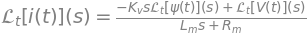

In [4]:
i_s = laplace_completa(i, t, s)
eq_i_s = Eq(i_s, solve(Eq(laplace_completa(eq_V.lhs,t,s), laplace_completa(eq_V.rhs,t,s)), i_s)[0])
eq_i_s

In [5]:
u_s = laplace_completa(u, t, s)
eq_u_s = Eq(u_s, solve(Eq(laplace_completa(eq_u.lhs,t,s), laplace_completa(eq_u.rhs,t,s)), u_s)[0])
eq_u_s

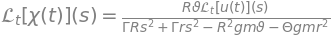

In [6]:
chi_s = laplace_completa(chi, t, s)
eq_chi_s = Eq(chi_s, solve(Eq(laplace_completa(eq_chi_ddot.lhs,t,s), laplace_completa(eq_chi_ddot.rhs,t,s)), chi_s)[0]).simplify()
eq_chi_s

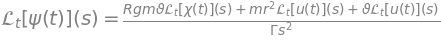

In [7]:
psi_s = laplace_completa(psi, t, s)
eq_psi_s = Eq(psi_s, solve(Eq(laplace_completa(eq_psi_ddot.lhs,t,s), laplace_completa(eq_psi_ddot.rhs,t,s)), psi_s)[0])
eq_psi_s

In [8]:
y_s = laplace_completa(y, t, s)
eq_y_s = Eq(y_s, solve(Eq(laplace_completa(eq_y.lhs,t,s), laplace_completa(eq_y.rhs,t,s)), y_s)[0])
eq_y_s

With the expressions transformed to the frequency domain, we can build the block diagram (in open loop) of our system.

![Picture title](Pictures/db-inicial.png)

$$\frac{R\vartheta}{\Gamma(R+r)s^2 - mg(\Theta r^2 + \vartheta R^2)}$$ is called $$G_1(s)$$ and you can simplify the block diagram as follows:

![Picture title](Pictures/db-intermediario.png)

We are now going to carry out the other operations to obtain only one block from our plant.
The cells below do the same, step by step, using Python functionality.

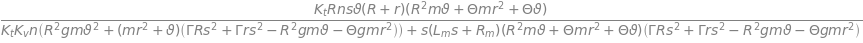

In [9]:
G1 = (eq_chi_s.rhs/u_s).simplify()

Gcima = (((Kt*n)/(Lm*s+Rm))*G1).simplify()

Gbaixo = ((R*g*m*v + (m*r**2+v)/G1)*(Kv/(s*(R**2*m*v + O*m*r**2 + O*v)))).simplify()

Gp = (Gcima/(1+Gcima*Gbaixo)*(R+r)).simplify()

Gp

So we get the transfer function from our plant (open loop), substituting the value of $$G_1(s)$$ shown below.

![Picture title](Pictures/db-final.png)

As discussed with teachers and other colleagues, for the present project we will dimension our controller to the $$Y(s)$$ variable directly.

Note that it will now be necessary to carry out such dimensioning, so that we can test later with disturbances in the wheel torque, a more interesting physical parameter in the present problem.

The closed loop with our controller is therefore as shown below.

![Picture title](Pictures/db-malha-fechada.png)

In [10]:
# Celula utilizada para conseguirmos pegar a expressão simbólica e transformá-la para Python, evitando erros na cópia
print_python(Gp)

K_t = Symbol('K_t')
R = Symbol('R')
n = Symbol('n')
s = Symbol('s')
vartheta = Symbol('vartheta')
r = Symbol('r')
m = Symbol('m')
Theta = Symbol('Theta')
K_v = Symbol('K_v')
g = Symbol('g')
Gamma = Symbol('Gamma')
L_m = Symbol('L_m')
R_m = Symbol('R_m')
e = K_t*R*n*s*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))


In [11]:
# Definição dos parâmetros numéricos

s = co.tf("s")

Theta = 0.028 # kg.m^2
R = 0.16 # m
m = 0.048 # kg
vartheta = 2.54e-5 #kg.m^2
r = 0.0296 #m
K_t = 0.1604 # N.m/A
K_v = 0.1186 # V.s/rad
R_m = 12 # ohm
L_m = 1.16e-3 # H
g = 9.8 # m/s^2
n = 40
Gamma = Theta*vartheta + m*(vartheta*(R**2) + Theta*(r**2))


Gp = K_t*R*n*s*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))

Let's, as a good practice, analyze the poles and zeros of our open-loop transfer function with the numerical parameters defined in the $\textit{briefing}$ of the project.

In [12]:
p_g = co.pole(Gp)
z_g = co.zero(Gp)
print(p_g, z_g)

[-1.03425992e+04  5.69671377e+00 -5.72218197e+00 -2.20289160e+00] [0.]


Our transfer function with the numerical values ​​is, in addition, as follows:

In [13]:
print("VERSAO NAO SIMPLIFICADA")
print(Gp)

# Podemos realizar algumas manobras para simplificar ainda mais nossa funcao de transferencia, printamos sua versao simplificada logo abaixo

aux_simplifica = 1/(Gp.num[0][0][0])
Gpsimp = Gp*aux_simplifica/aux_simplifica

print("VERSAO SIMPLIFICADA")
print(Gpsimp)

VERSAO NAO SIMPLIFICADA

                              9.492e-12 s
-----------------------------------------------------------------------
8.107e-16 s^4 + 8.387e-12 s^3 + 1.866e-11 s^2 - 2.729e-10 s - 6.021e-10

VERSAO SIMPLIFICADA

                           s
--------------------------------------------------------
8.542e-05 s^4 + 0.8836 s^3 + 1.966 s^2 - 28.75 s - 63.44



### 3. Controller Sizing

A PID controller can be thought of as follows:

$$G_c(s) = K_p (1+T_d s + \frac{1}{T_i s})$$

For which we must define the parameters $K_p$, $T_d$, $T_i$.

#### 3.1 Choice of parameters

The process of choosing the PID parameters took place interactively, through a *widget* that allows you to vary the value of the parameters and visualize the results obtained in a practical way.

In [14]:
@interact(Kp=(0.01, 1000), Td=(0.01, 15), Ti=(0.01, 10))
def sistema(Kp, Td, Ti):
    Gc = Kp*(1+Td*s + 1/(Ti*s))
    co.sisotool(co.minreal(Gp*Gc, verbose=False))

interactive(children=(FloatSlider(value=500.005, description='Kp', max=1000.0, min=0.01), FloatSlider(value=7.…

Using the interactive technique, operationally allowed given current computational tools (in this case, Python), it was possible to design a PID that satisfactorily meets the desired requirements. The parameter values ​​will be:

$$K_{p} = 150$$

$$T_{d} = 10$$

$$T_{i} = 0.5$$

It is observed that the margin gain may show inconsistency given the requirement of the statement, but it is clear that this is natural given that it is impossible to make the margin gain be greater than 10dB, since the frequency graph is asymptotic to - 180º.

In [15]:
Kp = 150
Td = 10
Ti = 0.5

#### 3.2 Answer obtained

Once the controller parameters are defined, it is possible to observe the plant response characteristics with the dimensioned controller. The cell below simplifies and exposes the values ​​of interest for this work, with the innovation and creativity of the members when calculating them with functions customized especially for this work.

In [16]:
Gc = Kp*(1+Td*s + 1/(Ti*s))
Gfinal = co.minreal(Gc*Gp, verbose=False)
Gfmf  = co.minreal(co.feedback(Gfinal))

0 states have been removed from the model


Saída em steady-state: 0.9990436470502209
Máximo sobressinal: 0.00 %
Tempo de subida: 0.016108161121310735


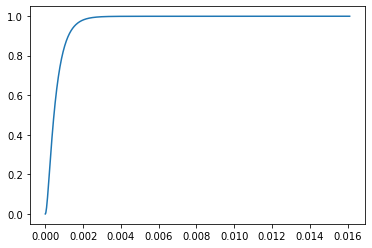

In [17]:
def acha_ts(y, t):
    for i, val in enumerate(y):
        if val >= y[-1]:
            return t[i]
    return np.nan

y, t = co.step(Gfmf)
print(
f"""Saída em steady-state: {y[-1]}
Máximo sobressinal: {(max(y)-y[-1])*100:.2f} %
Tempo de subida: {acha_ts(y, t)}"""
)
plt.plot(t, y)

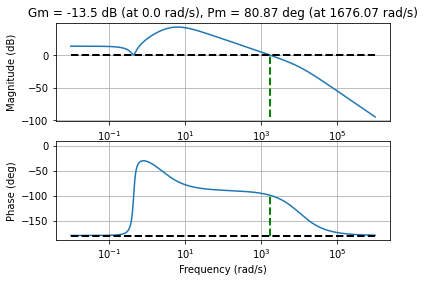

In [18]:
plot_margins(Gfinal)

### 4. Control effort considerations

For every control project, it is necessary to try to evaluate the control effort, since a given solution may not be the most efficient in terms of effort to carry out. Control effort is the amount of energy or force required for the controller to perform its activity correctly.

In this case, we analyze the current demanded by the system. To do this, we modified the block diagram as follows:

![Picture title](Pictures/db-esforco.png)

How simplified it is:

![Picture title](Pictures/db-esforco-simp.png)

In [19]:
G1 = R*vartheta/(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)

Gesfcima = Gc*1/(L_m*s + R_m)
Gesfbaixo = ((1/Gc*K_v/(s*(R**2*m*vartheta+Theta*m*r**2+Theta*vartheta))
    *(R*g*m*vartheta+(m*r**2 + vartheta)/G1)*1/(R+r)+1)*K_t*n*G1*(R+r))

Gesf = co.minreal(co.feedback(Gesfcima, Gesfbaixo))
print(Gesf)

3 states have been removed from the model

1.293e+06 s^4 + 1.293e+05 s^3 - 4.182e+07 s^2 - 4.208e+06 s - 8.416e+06
-----------------------------------------------------------------------
     s^4 + 1.034e+04 s^3 + 1.758e+07 s^2 + 1.419e+06 s + 2.77e+06



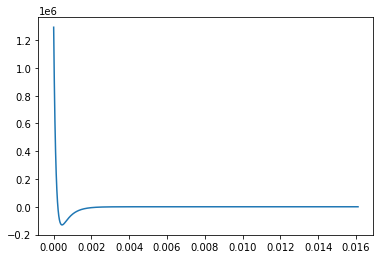

In [20]:
y, t = co.step(Gesf)
plt.plot(t, y)

It is noticed that the curve obtained for the control effort has the usual format. However, as expected (given the fast dynamics of the system as a whole, including that of the sized controller) the current drawn has an extremely high amplitude. This inaccuracy comes naturally as the nature of the system is extremely fast and we need to get the ball back to equilibrium quickly. This makes the current consumption appear higher than what the actuator suggested in the statement supports.

### 5. Disturbance Applications

As the present project is physically intuitive and intriguing in terms of interactions with external users, it is extremely valid to observe the behavior of the system with the designed controller when exposed to external disturbances. In practical terms, the setpoint, $Y_{sp}(s) = 0$, is considered null, since the intention is to observe how the assembly reacts when trying to bring the ball up, in the unstable equilibrium position, in which the value of $Y$ is just null. The figure below presents the block diagram with the consideration of the disturbance.

![Picture title](Pictures/db-disturbios.png)


4 main tests will be performed, varying the behavior of $D(s)$, chosen following the usual control projects and the curiosity of the members, who thought of plausible tests that would be performed by external users when contacting the system.

#### 5.1 Step

The first test to be performed represents the consideration of $D(s)$ as a step. Physically, it would be as if the ball suffered efforts equivalent to being constantly pushed 1cm (amplitude of the chosen step) out of its equilibrium position. The system must be able to make it come back, that is, to compensate for this disturbance.

The code below exposes the construction of this test. The rung application was made from $0.25\;s$.

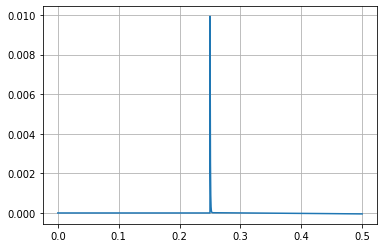

In [21]:
t = np.linspace(0, 500e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//2:] = 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

It is noticed that the system responds well to this disturbance, making the ball return to its equilibrium position very quickly.

#### 5.2 Impulse

One of the most interesting tests to be done is equivalent to an external "flicker" on the ball. It is expected again that the system will be able to make it return to its unstable equilibrium position quickly.

The code below exposes the construction of this test. Impulse application was done in $0.5\;s$.

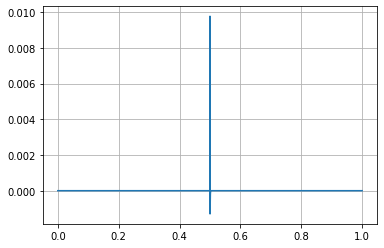

In [22]:
t = np.linspace(0, 1000e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//2] = 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

It is noticed that the system responds well to this disturbance, making the ball return to its equilibrium position very quickly. However, as expected physically, the ball goes through a kind of supersignal, that is, it returns to equilibrium but passes through a small distance. This error is corrected soon after, since it returns to the equilibrium position in the opposite direction.

#### 5.3 Alternation of impulses in the same direction

For this third test, impulses will be used in the same direction at different time points. Physically, it represents two "flips" in the same sense. The first happens to $0.25\;s$ and the second to $0.5\;s$.

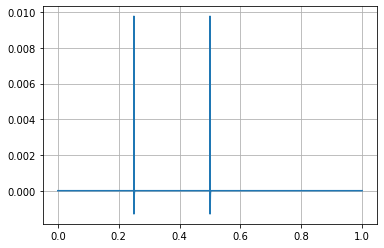

In [23]:
t = np.linspace(0, 1000e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//4] = 0.01

entrada[len(t)//2] = 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

It is noticed that the system responds well to this disturbance, making the ball return to its equilibrium position very quickly both times. However, just as in the case with just a "flicker", as expected physically, the ball goes through a kind of signal, that is, it returns to equilibrium but passes through a small distance. This error is corrected soon after, since it returns to the equilibrium position in the opposite direction.

#### 5.4 Alternating impulses with opposite directions

In the last test, something similar to the previous one is performed, but with two "flips" in opposite directions. The first happens to $0.25\;s$ and the second to $0.5\;s$.

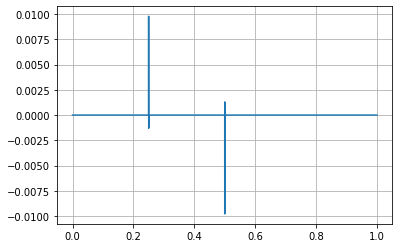

In [24]:
t = np.linspace(0, 1000e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//4] = 0.01

entrada[len(t)//2] = - 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

It is noticed that the system responds well to this disturbance, making the ball return to its equilibrium position very quickly both times. However, as in the previous cases, as expected physically, the ball goes through a kind of overhang, that is, it returns to equilibrium but passes through a small distance. This error is corrected soon after, since it returns to the equilibrium position in the opposite direction, for both impulses performed.

### 6. Analysis of results

As with any control project, the plant for which the controller would be developed must be well understood. Therefore, the present discussions are important to the point that they begin by valuing its analysis, that is, the painstaking work of assembling the block diagram and understanding the dynamic equations of the system of interest. There is an important feedback relationship that would not be noticed by simply viewing the equations. With a well-assembled block diagram in hand, it was possible to proceed with the dimensioning without any doubts about possible errors in the interpretation of the problem, which ensured accuracy in the following steps.

In terms of dimensioning, several facilitating techniques were seen that provide guidelines for the tests to be performed. With the help of Python and current computational potential, extremely easy and fast interactive methods can be used to obtain proper parameter values. Therefore, the dimensioning was simple and intuitive, allowing greater care in the analysis item, which adds value to the project, than in the mathematical-operational item, just a means to obtain interesting results.

Next, a comparison is made between the requirements of the statement and whether they were met or not (if not, a small justification is provided, which were also mentioned throughout the previous cells):

- $e_{SS}$ static regime error equal to zero -> Fulfilled
- Maximum supersisnal $M_{p}$ less than $10\%$ -> Fulfilled
- $t_{S}$ settlement time of $2\%$ compatible with system dynamics -> Fulfilled
- $G_{M}$ gain margin greater than $10dB$ -> Not fulfilled, since the frequency graph is asymptotic at -180º, which does not allow the requirement to be met
- $\phi_{M}$ phase margin greater than 45º -> Fulfilled
- Rejection for step-type disturbance -> Fulfilled (however, it was not possible to determine the maximum step value that the system can reject and make the ball return to the unstable equilibrium position, since for any step amplitude the system will showed capable of doing so. Such impossibility is natural, since mathematical simplifications were made throughout development, such as that of sine for small angles. This does not imply that there is no maximum value, since we physically know that this value is exists, but it is just not possible to obtain it with the modeling done and held for the present work)
- Control effort compatible with maximum actuator current -> Not met (given the extremely fast nature of the system and the fact that we need to get the ball to return to equilibrium position quickly, current consumption proved to be higher than what the actuator suggested in the statement supports)
- Check how far from the balance point the ball can be so that the control system can still achieve the goals -> As for the step-type disturbance item, it was not possible to determine how far from the balance point the ball may be there for the control system to still be able to achieve the objectives, since for any amplitude the system has shown itself capable of doing so. This impossibility is, again, natural, since mathematical simplifications were made throughout development, such as sine for small angles. This does not imply that there is no maximum value, since we physically know that this value exists, but that it is just not possible to obtain it with the modeling done and maintained for the present work. In general, it is expected that it will be able to do a good control up to a little more than 14º of angular displacement, given that this is the threshold value for the sine simplification for small angles to still be satisfactory.

The statement initially suggests the use of cascading controllers for a second state variable (which in the present case would be speed). The reason for this proposition is based on the fact that we have velocity dynamics much faster than the position dynamics, which usually indicates the need for cascade controllers. However, after long attempts and some conferences with teachers, its use proved unnecessary and only one PID was enough to meet the objectives of the present work.

Regarding the disturbance tests in $Y(s)$, it was possible to notice that the controller responded well to the situations set up by the team. Interesting and real situations were organized, with physical associations to the "flips" that external users would perform in the system. It is possible to notice a fast and well-behaved response, configuring a good sizing performed previously.

### 7. Conclusions

Once the control system has been dimensioned, the graphics obtained and their representations discussed, considering physical aspects, this report can be closed with general conclusions of the work. Initially, the physical character of the problem should be emphasized, that is, as it is a plant with features and needs (requirements) common in the field of engineering, enormous value is given to the treatment of its equations and to the solution by analytical and computational methods . This value, combined with considerations developed in different languages ​​and libraries, adds value to engineering both in the academic and market senses.

Additionally, given the didactic nature of the discipline, the relevance of deepening and developing different methods for the resolution of this work should be mentioned. As seen in theory, in class, one can put the knowledge received into practice and observe, with one's own eyes, the trade-off that is always present in engineering: between precision and computational-analytic effort, generally connected with the time taken to obtain of a solution. It takes, therefore, to the team's posterity, the contact with the skill when looking for not an ideal solution, but a sufficiently adequate solution (always safe) to carry out future projects and analyze physical phenomena.

Finally, contact with important tools for the current industry, such as Python and its libraries (symbolic, related to control and algebraic), complete and add to the work another valuable learning experience. The present study ends, not only with the training of qualitative skills, but also with the improvement of technical-operational skills, which are in no way comparable to each other, being unique and important in different ways for the achievement of an academic study and an engineering project.